In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random

In [2]:
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


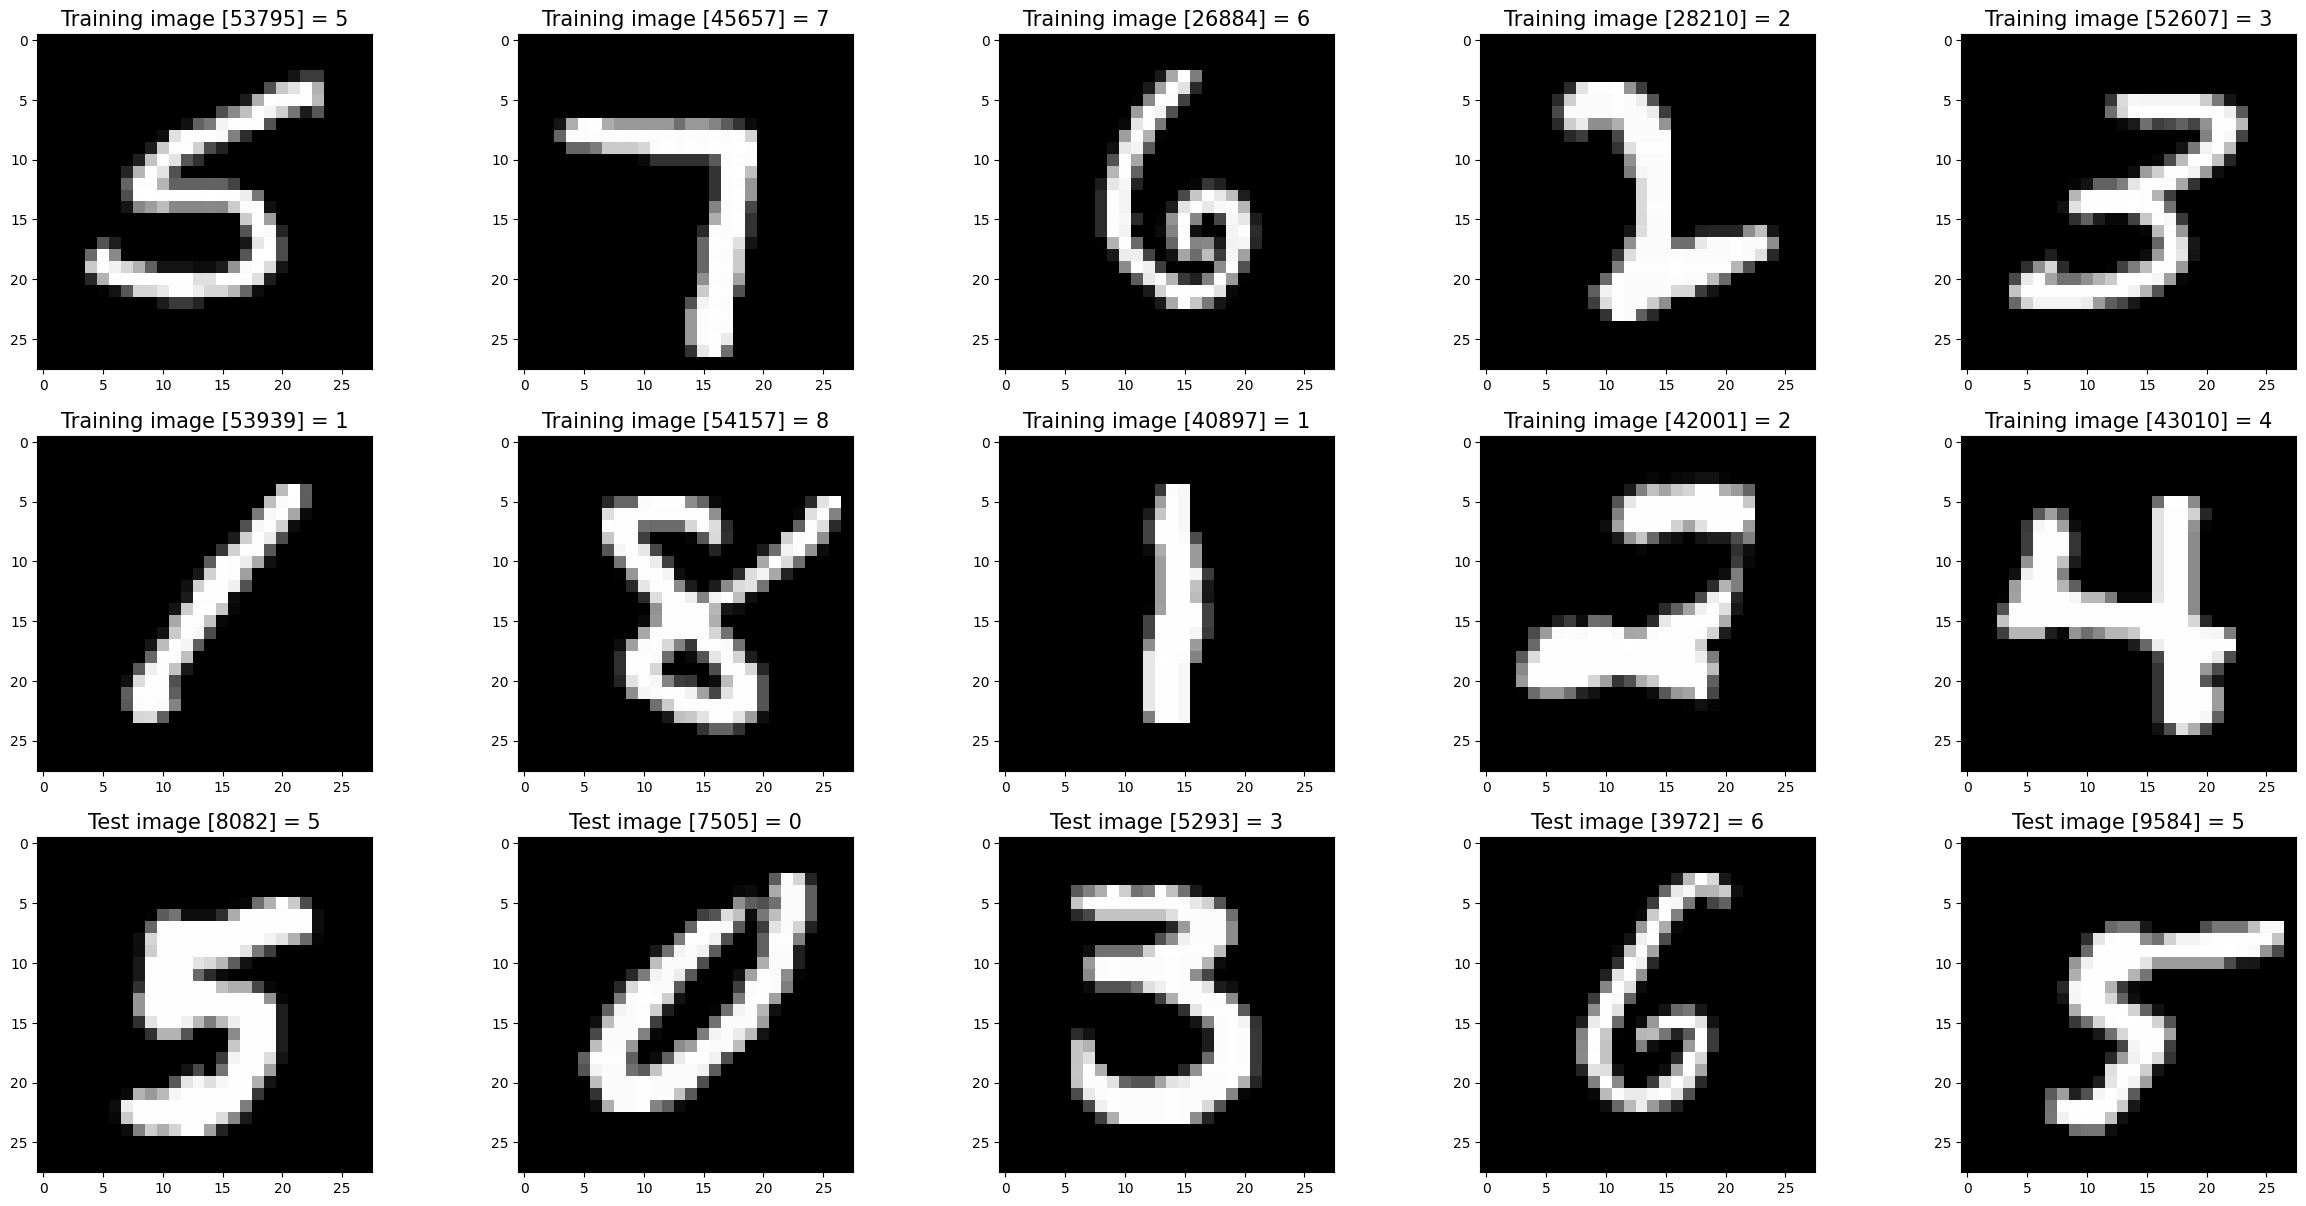

In [3]:
# Verify Reading Dataset via MnistDataloader class
# Import necessary libraries
%matplotlib inline
import random
import matplotlib.pyplot as plt
from os.path import join
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set file paths based on the location of MNIST Datasets in Google Drive
input_path = '/content/drive/MyDrive/Colab Notebooks/mnist'  # Update this path
training_images_filepath = join(input_path, 'train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels.idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images.idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels.idx1-ubyte')

# Helper function to show a list of images with their relating titles
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images) / cols) + 1
    plt.figure(figsize=(30, 20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if title_text != '':
            plt.title(title_text, fontsize=15)
        index += 1

# Load MNIST dataset using MnistDataloader class
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath,
                                    test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Show some random training and test images
images_2_show = []
titles_2_show = []

# Randomly select training images
for i in range(0, 10):
    r = random.randint(0, 59999)  # Adjusted to be within valid index range for training set
    images_2_show.append(x_train[r])
    titles_2_show.append('Training image [' + str(r) + '] = ' + str(y_train[r]))

# Randomly select test images
for i in range(0, 5):
    r = random.randint(0, 9999)  # Adjusted to be within valid index range for test set
    images_2_show.append(x_test[r])
    titles_2_show.append('Test image [' + str(r) + '] = ' + str(y_test[r]))

# Display the images with titles
show_images(images_2_show, titles_2_show)

In [4]:
# Convert to numpy arrays and normalize the data
x_train = np.array(x_train).astype(np.float32) / 255.0  # Normalize to [0, 1]
y_train = np.array(y_train)
x_test = np.array(x_test).astype(np.float32) / 255.0    # Normalize to [0, 1]
y_test = np.array(y_test)

# Reshape data for PyTorch (N_samples x N_features)
x_train = x_train.reshape(-1, 28 * 28)  # Flatten images to vectors of size 784
x_test = x_test.reshape(-1, 28 * 28)

# Create PyTorch datasets and loaders
train_dataset = TensorDataset(torch.tensor(x_train), torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(x_test), torch.tensor(y_test))

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128)

#### MLP Architecture

In [5]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    # Input layer to first hidden layer
    self.fc1 = nn.Linear(28*28, 512)
    # First hidden layer to second hidden layer
    self.fc2 = nn.Linear(512, 256)
    # Second hidden layer to third hidden layer
    self.fc3 = nn.Linear(256, 128)
    # Third hidden layer to output layer
    self.fc4 = nn.Linear(128, 10)

    # dropout layer to prevent overfitting
    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = x.view(-1, 28*28)
    x = torch.relu(self.fc1(x))
    x = self.dropout(x)
    x = torch.relu(self.fc2(x))
    x = self.dropout(x)
    x = torch.relu(self.fc3(x))
    hidden_output = x
    x = self.fc4(x)
    return x, hidden_output



In [6]:
# instantiate the model
model = MLP()

In [7]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)


In [8]:
# Training the model

num_epochs = 50
for epoch in range(num_epochs):
  model.train()
  for images, labels in train_loader:
    optimizer.zero_grad()
    outputs, _ = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Streaming output truncated to the last 5000 lines.
Epoch [40/50], Loss: 0.0266
Epoch [40/50], Loss: 0.0064
Epoch [40/50], Loss: 0.0801
Epoch [40/50], Loss: 0.0398
Epoch [40/50], Loss: 0.0243
Epoch [40/50], Loss: 0.0812
Epoch [40/50], Loss: 0.0161
Epoch [40/50], Loss: 0.0222
Epoch [40/50], Loss: 0.0899
Epoch [40/50], Loss: 0.0202
Epoch [40/50], Loss: 0.0337
Epoch [40/50], Loss: 0.0191
Epoch [40/50], Loss: 0.0374
Epoch [40/50], Loss: 0.0170
Epoch [40/50], Loss: 0.0166
Epoch [40/50], Loss: 0.0125
Epoch [40/50], Loss: 0.0031
Epoch [40/50], Loss: 0.0400
Epoch [40/50], Loss: 0.0069
Epoch [40/50], Loss: 0.0183
Epoch [40/50], Loss: 0.0068
Epoch [40/50], Loss: 0.0352
Epoch [40/50], Loss: 0.0209
Epoch [40/50], Loss: 0.0480
Epoch [40/50], Loss: 0.0270
Epoch [40/50], Loss: 0.0452
Epoch [40/50], Loss: 0.0403
Epoch [40/50], Loss: 0.0132
Epoch [40/50], Loss: 0.0213
Epoch [40/50], Loss: 0.0298
Epoch [40/50], Loss: 0.0207
Epoch [40/50], Loss: 0.0155
Epoch [40/50], Loss: 0.0374
Epoch [40/50], Loss: 0.03

In [9]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Evaluating the model on test data
model.eval()

all_preds = []
all_labels = []

with torch.no_grad(): # disabling the gradient for testing
  correct = 0
  total = 0
  for images, labels in test_loader:
    outputs, _ = model(images)
    _, predicted = torch.max(outputs.data, 1) # return max predicted value and corresponding index value

    total += labels.size(0) # increasing total by no. of sample in a batch
    correct += (predicted == labels).sum().item()

    all_preds.extend(predicted.numpy())
    all_labels.extend(labels.numpy())


# Classification report
print(f'Test accuracy: {100 * correct / total:.2f}%')
# Calculate overall precision, recall, and F1 score
overall_precision = precision_score(all_labels, all_preds, average='weighted')
overall_recall = recall_score(all_labels, all_preds, average='weighted')
overall_f1 = f1_score(all_labels, all_preds, average='weighted')

# Print overall metrics
print(f'Overall Precision: {overall_precision:.4f}')
print(f'Overall Recall: {overall_recall:.4f}')
print(f'Overall F1 Score: {overall_f1:.4f}')


Test accuracy: 98.56%
Overall Precision: 0.9856
Overall Recall: 0.9856
Overall F1 Score: 0.9856


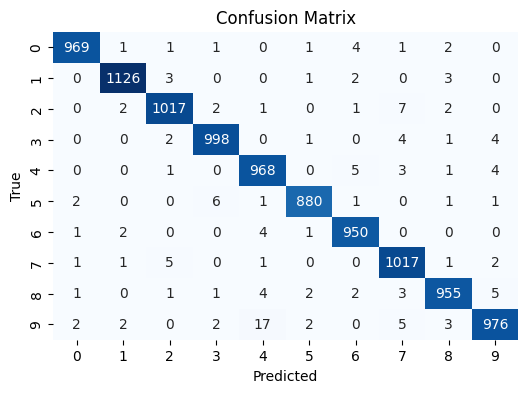

In [10]:
from sklearn.metrics import confusion_matrix
# !pip install seaborn
import seaborn as sns

# plotting the confusion matrix

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
          xticklabels=[str(i) for i in range(10)], yticklabels= [str(i) for i in range(10)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [11]:
# To show prediction
def show_predictions(images):
  plt.figure(figsize=(12,6))
  for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i].reshape(28, 28), cmap=plt.cm.gray)
    plt.title(f'Predicted: {predicted[i].item()}')

### Creating and training the random forest classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(x_train, y_train)

# making prediction
y_pred = rf_classifier.predict(x_test)

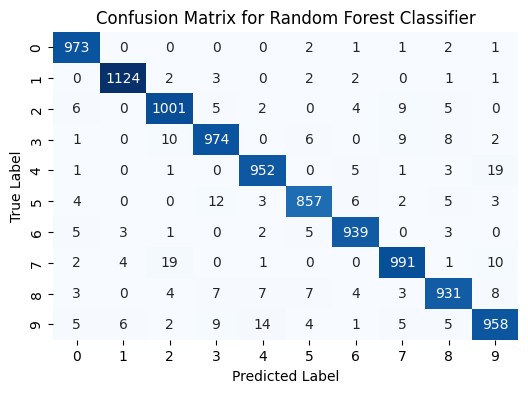

Overall Precision: 0.9700
Overall Recall: 0.9700
Overall F1 Score: 0.9700
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.97      0.96      0.96       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [13]:
# Random Forest model evaluation
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

# Calculate overall precision, recall and F1 score
overall_precision = precision_score(y_test, y_pred, average='weighted')
overall_recall = recall_score(y_test, y_pred, average='weighted')
overall_f1 = f1_score(y_test, y_pred, average='weighted')

# Print overall metrics
print(f'Overall Precision: {overall_precision:.4f}')
print(f'Overall Recall: {overall_recall:.4f}')
print(f'Overall F1 Score: {overall_f1:.4f}')

# Print classification report for detailed metrics per class
report = classification_report(y_test, y_pred)
print(report)

### Comparison of MLP against random forest classifier model
###### Both model misclassified 9 as 4. 14 times and 17 times by MLP and RF model respectively. 12 times digit 5 is classified as 3 by RF while it is 6 times by MLP model. Similar case is observed where 7 is predicted as 2. As, we can observe here that MLP model performed better than RF model.

### Logistic Regression Model

In [14]:
from sklearn.linear_model import LogisticRegression
# Creating a Logistic Regression Classifier
log_reg_classifier = LogisticRegression(max_iter=1000)
log_reg_classifier.fit(x_train, y_train)

# Making predictions on the test set
y_pred = log_reg_classifier.predict(x_test)

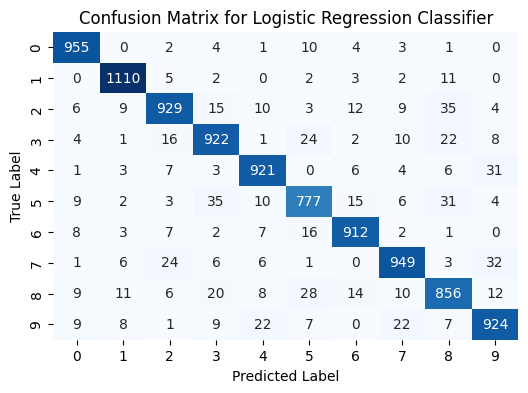

Overall Precision: 0.9253
Overall Recall: 0.9255
Overall F1 Score: 0.9253
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.91      0.91      0.91      1010
           4       0.93      0.94      0.94       982
           5       0.90      0.87      0.88       892
           6       0.94      0.95      0.95       958
           7       0.93      0.92      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



In [15]:
# Model Evaluation
# Evaluate the model: confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression Classifier')
plt.show()

# Calculate overall precision, recall and F1 score
overall_precision = precision_score(y_test, y_pred, average='weighted')
overall_recall = recall_score(y_test, y_pred, average='weighted')
overall_f1 = f1_score(y_test, y_pred, average='weighted')

# Print overall metrics
print(f'Overall Precision: {overall_precision:.4f}')
print(f'Overall Recall: {overall_recall:.4f}')
print(f'Overall F1 Score: {overall_f1:.4f}')

# Print classification report for detailed metrics per class
report = classification_report(y_test, y_pred)
print(report)

##### **Comparison of MLP against Logistic Regression Model **
As we can observe from confusion matrix, there are many digits are classified in significant number. commonly confused digits are - 5 is misclassified as 3 and 7 is misclassifed as 2

# Comparison of TSNE for untrained and trained MLP

### Trained MLP

In [16]:
# instantiate model
model = MLP()

In [17]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Training the model

num_epochs = 50
for epoch in range(num_epochs):
  model.train()
  for images, labels in train_loader:
    optimizer.zero_grad()
    outputs, _ = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Streaming output truncated to the last 5000 lines.
Epoch [40/50], Loss: 0.0334
Epoch [40/50], Loss: 0.0194
Epoch [40/50], Loss: 0.0128
Epoch [40/50], Loss: 0.0254
Epoch [40/50], Loss: 0.0160
Epoch [40/50], Loss: 0.0306
Epoch [40/50], Loss: 0.0055
Epoch [40/50], Loss: 0.0123
Epoch [40/50], Loss: 0.0284
Epoch [40/50], Loss: 0.0032
Epoch [40/50], Loss: 0.0218
Epoch [40/50], Loss: 0.0348
Epoch [40/50], Loss: 0.1062
Epoch [40/50], Loss: 0.0217
Epoch [40/50], Loss: 0.0171
Epoch [40/50], Loss: 0.0200
Epoch [40/50], Loss: 0.0095
Epoch [40/50], Loss: 0.0094
Epoch [40/50], Loss: 0.0122
Epoch [40/50], Loss: 0.0107
Epoch [40/50], Loss: 0.0024
Epoch [40/50], Loss: 0.0639
Epoch [40/50], Loss: 0.0526
Epoch [40/50], Loss: 0.1072
Epoch [40/50], Loss: 0.0281
Epoch [40/50], Loss: 0.0126
Epoch [40/50], Loss: 0.0097
Epoch [40/50], Loss: 0.0009
Epoch [40/50], Loss: 0.0183
Epoch [40/50], Loss: 0.0314
Epoch [40/50], Loss: 0.0036
Epoch [40/50], Loss: 0.0166
Epoch [40/50], Loss: 0.0328
Epoch [40/50], Loss: 0.01

In [18]:
# Extract features from the third hidden layer for trained model
model.eval()
hidden_outputs_trained = []
labels_trained = []

with torch.no_grad():
    for images, labels in test_loader:
        _, hidden_output = model(images)  # Get both output and hidden layer output
        hidden_outputs_trained.append(hidden_output)
        labels_trained.append(labels)

hidden_outputs_trained = torch.cat(hidden_outputs_trained).numpy()
labels_trained = torch.cat(labels_trained).numpy()

### Untrained Model

In [19]:
# Create an untrained model
untrained_model = MLP()

# Extract features from the second hidden layer for untrained model
untrained_model.eval()
hidden_outputs_untrained = []
labels_untrained = []

with torch.no_grad():
    for images, labels in test_loader:
        _, hidden_output = untrained_model(images)  # Get both output and hidden layer output
        hidden_outputs_untrained.append(hidden_output)
        labels_untrained.append(labels)

hidden_outputs_untrained = torch.cat(hidden_outputs_untrained).numpy()
labels_untrained = torch.cat(labels_untrained).numpy()

### Applying TSNE

In [20]:
from sklearn.manifold import TSNE

# Apply t-SNE on trained model outputs
tsne_trained = TSNE(n_components=2, random_state=42).fit_transform(hidden_outputs_trained)

# Apply t-SNE on untrained model outputs
tsne_untrained = TSNE(n_components=2, random_state=42).fit_transform(hidden_outputs_untrained)

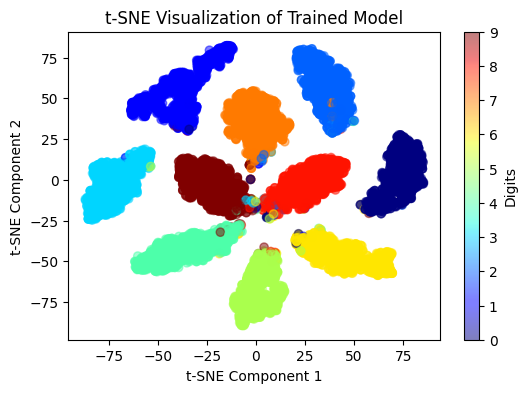

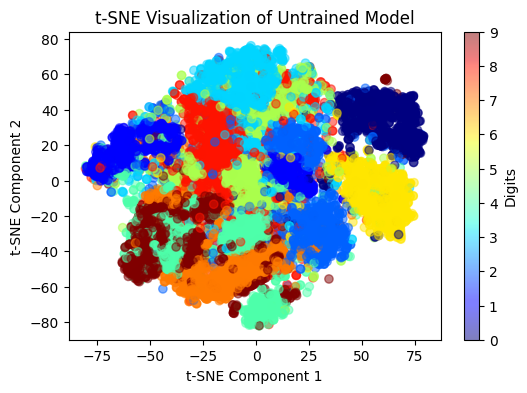

In [21]:
import matplotlib.pyplot as plt

def plot_tsne(tsne_results, labels, title):
    plt.figure(figsize=(6, 4))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='jet', alpha=0.5)
    plt.colorbar(scatter, ticks=range(10), label='Digits')
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

# t-SNE for trained model
plot_tsne(tsne_trained, labels_trained, 't-SNE Visualization of Trained Model')

# t-SNE for untrained model
plot_tsne(tsne_untrained, labels_untrained, 't-SNE Visualization of Untrained Model')

###### **Comparison of tSNE for trained and untrained MLP **
for the trained model, we can observe 9 different clusters representing different digits (0-9), that indicates that trained MLP has learned 9 different classes
for the untrained model, we got very intermixed or dispersed pattern that indicates without training, network can't provide meaningful representation of the input data

# Fashion MNIST

###### Loading the dataset

In [22]:

# Define transformation for normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Fashion-MNIST dataset
fashion_train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
fashion_test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders
fashion_train_loader = DataLoader(dataset=fashion_train_dataset, batch_size=128, shuffle=True)
fashion_test_loader = DataLoader(dataset=fashion_test_dataset, batch_size=128, shuffle=False)

100%|██████████| 26.4M/26.4M [00:05<00:00, 4.47MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 214kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:06<00:00, 678kB/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 25.0MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [23]:
# Extract features from the third hidden layer for Fashion-MNIST
fashion_hidden_outputs = []
fashion_labels = []

model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for images, labels in fashion_test_loader:
        _, hidden_output = model(images)  # Get both output and hidden layer output
        fashion_hidden_outputs.append(hidden_output)
        fashion_labels.append(labels)

fashion_hidden_outputs = torch.cat(fashion_hidden_outputs).numpy()
fashion_labels = torch.cat(fashion_labels).numpy()

In [24]:
# Extract features from the third hidden layer for MNIST
hidden_outputs_mnist = []
labels_mnist = []

with torch.no_grad():
    for images, labels in test_loader:
        _, hidden_output = model(images)  # Get both output and hidden layer output
        hidden_outputs_mnist.append(hidden_output)
        labels_mnist.append(labels)

hidden_outputs_mnist = torch.cat(hidden_outputs_mnist).numpy()
labels_mnist = torch.cat(labels_mnist).numpy()

In [25]:
# Applying TSNE
from sklearn.manifold import TSNE

# Apply t-SNE on MNIST outputs
tsne_mnist = TSNE(n_components=2, random_state=42).fit_transform(hidden_outputs_mnist)

# Apply t-SNE on Fashion-MNIST outputs
tsne_fashion = TSNE(n_components=2, random_state=42).fit_transform(fashion_hidden_outputs)

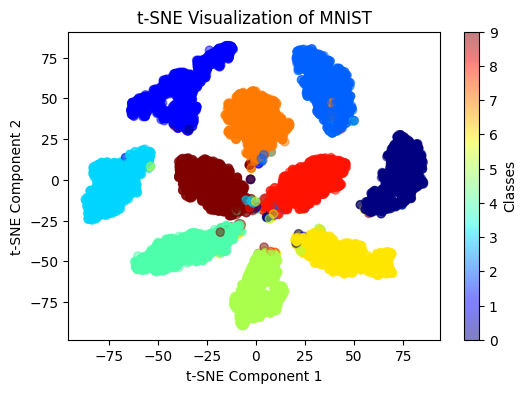

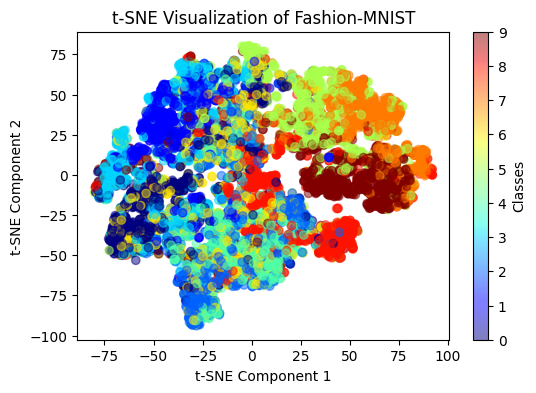

In [26]:
import matplotlib.pyplot as plt

def plot_tsne(tsne_results, labels, title):
    plt.figure(figsize=(6, 4))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='jet', alpha=0.5)
    plt.colorbar(scatter, ticks=range(10), label='Classes')
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

# Plot t-SNE for MNIST
plot_tsne(tsne_mnist, labels_mnist, 't-SNE Visualization of MNIST')

# Plot t-SNE for Fashion-MNIST
plot_tsne(tsne_fashion, fashion_labels, 't-SNE Visualization of Fashion-MNIST')

##### **Comparison of tSNE for embeddings(third hidden layer) generated by Fashion MNIST and MNIST**
Both dataset have similar sizes and structures (28*28) grayscale images, they represent digit and clothing items respectively.
Since our model is trained on MNIST dataset, hence embedding generated using MNIST datapoints will form clusters as we can observe 9 different clusters representing 9 different digits (0-9).

We can observe messy visualization of embeddings for Fashion MNIST because our model is trained on MNIST dataset and weights are trained accordingly MNIST dataset hence no structure/pattern/cluster can be observed here.